# 7. Bayesian inference 2 - encapsulating models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/07-bayesian-inference-2.ipynb)

__Date__: Wednesday, Sept 11, 2024

## Learning outcomes
- defining complex Bayesian models
- connection between Bayesian models and directed acyclic graphs
- encapsulating Bayesian models with a `tfd.JointDistributionCoroutine`


## Bayesian models

In the previous session, we looked at several aspects of Bayesian inference including probability distributions of data, key mathematical considerations of distribution choices, and stimating parameters based on data. We now want to bring this all together within the context of epidemic models by encapsulating these aspects of our models so we can use more complex inference schemes.

Bayesian inference a broad term that refers to the formulation and computation of the conditional probability $p(\theta | x) \propto p(\theta) p(X|\theta)$. The collection of prior distributions $p(\theta)$ along with the likelihood function $p(X|\theta)$ is what we refer to as our __Bayesian model__. In the [epidemic likelihoods](https://colab.research.google.com/drive/1fUAT9ALNNYJHQeMPxLUjgLB3US_Z8rb6) session, the likelihood function was defined using the $L(\theta| X)$ notation. This is to highlight that it is a function of the model parameters. These two are used interchangeably in the literature (somewhat confusing).

We wnat to develop a Bayesian workflow that can be followed and repeated when doing any modelling exercise. This typically includes  three steps
1. model building
2. inference
3. model checking/improvement
This section will focus on the first step of this process - model building.
```

A big advantage of a Bayesian modelling approach is the clear flow of information which links model parameters to the data generating process. In order to build a Bayesian model, it is best to think about _how_ the available data was generate from a process perspective. With epidemics, the data we often see are case counts which can be modelled with a Poisson process as shown earlier. This can be represented with a Directed Acyclic Graph (DAG) which is a collection of verticies and edges that are directed from one vertex to another, but never form a closed loop. We use use them to represent the connections and dependencies in Bayesian models. Take the example of the chain binomial SIR model we used in the [epidemic likelihoods](https://colab.research.google.com/drive/1fUAT9ALNNYJHQeMPxLUjgLB3US_Z8rb6) session. The DAG for that model can be written as

In [ ]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!apt install amsmath

!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [966 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,224 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy I

In [ ]:
# @title
%load_ext tikzmagic

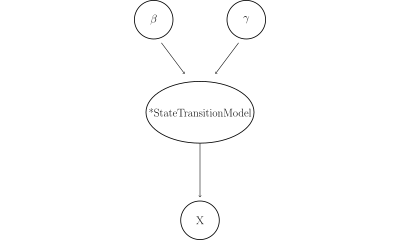

In [ ]:
%%tikz -S test_output.tikz -f svg

% priors
\draw [line width=1.5pt ] (2, 15) circle (1.25cm)  node {\huge $\beta$};
\draw [line width=1.5pt ] (8, 15) circle (1.25cm) node {\huge $\gamma$} ;

% model
\draw [line width=1.5pt ] (5,9) ellipse (3.5cm and 2cm) node {\huge *StateTransitionModel};

% data
\draw [line width=1.5pt ] (5,2) circle (1.25cm) node {\huge X} ;

% lines
\draw [line width=1pt, ->] (2.5, 13.5) -- (4, 11.5);
\draw [line width=1pt, ->] (7.5, 13.5) -- (6, 11.5);
\draw [line width=1pt, ->] (5, 7) -- (5, 3.5);

The top two nodes are the priors on the model parameters, $\beta,
\gamma$, the middle node is the model itself (can use any of the `*StateTransitionModel` types within `gemlib`), and the output of the DAG is the observed data $X$.

We can wrap this DAG up in a function which we can turn into a JointDistributionCoroutine. The rest of this session will be implemented using Tensorflow as opposed to Numpy (with the exceptions of defining constants).  

In [ ]:
from warnings import warn

try:
    import google.colab
    !pip install -Uq git+https://gitlab.com/gem-epidemics/gemlib.git
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 19.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions

DTYPE = tf.float32

## `tfd.JointDistributionCoroutine`

In TensorFlow Probability (TFP), `JointDistributionCoroutine` is a flexible way to define complex probabilistic models, often used for Bayesian inference. It allows you to create a joint distribution using Python coroutines (functions that use yield), which lets you specify how the different random variables in your model are related. The advantage we get is that it combines the priors and likelihoods so we can get log-probabilities of the entire model.

__Key Concepts__

- _Joint distributions_ : a joint distribution represents a probability distribution over multiple random variables. In this case, `JointDistributionCoroutine` enables you to model such distributions using coroutines
- _Coroutines_ : a coroutine is a function that can yield values, which allows it to be paused and resumed. `JointDistributionCoroutine` leverages this to allow complex models to be defined in a flexible, step-by-step way.

__How It Works__

When you define a JointDistributionCoroutine, you write a generator function that yields the distributions of your model's random variables. The yield statements define the distribution of each variable, and can depend on previously defined variables.

This approach is useful when the dependencies between the random variables are complex, or when you want to build the model programmatically.

Here is a simple example using a Normal distribution.


In [ ]:
def model():
    # Define the prior for a mean
    x = yield tfd.Normal(loc=0., scale=1., name='prior_mean')

    sigma = tf.constant(2., DTYPE)

    # Define another variable whose distribution depends on the previous variable
    y = yield tfd.Normal(loc=x, scale=sigma, name='y')

joint = tfd.JointDistributionCoroutine(model)

In [ ]:
joint.sample()

StructTuple(
  prior_mean=<tf.Tensor: shape=(), dtype=float32, numpy=-0.70113957>,
  y=<tf.Tensor: shape=(), dtype=float32, numpy=-0.20788372>
)

What about more than 1 sample at a time?

In [ ]:
Root = tfd.JointDistributionCoroutine.Root

In [ ]:
def model():
    # Define the prior for a mean
    x = yield Root(tfd.Normal(loc=0., scale=1., name='prior_mean'))

    sigma = tf.constant(2., DTYPE)

    # Define another variable whose distribution depends on the previous variable
    y = yield tfd.Normal(loc=x, scale=sigma, name='y')

joint = tfd.JointDistributionCoroutine(model)

In [ ]:
joint.sample(10)

StructTuple(
  prior_mean=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([-1.9552445 ,  1.920605  , -0.7151455 ,  0.0355459 ,  1.2405422 ,
           -1.0168447 ,  0.23623134,  2.0381866 , -1.0601188 ,  0.55893636],
          dtype=float32)>,
  y=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([-1.8734226 , -0.24922442,  2.4317672 , -0.3861875 ,  1.0211346 ,
            0.5300714 ,  2.6181717 ,  3.0738974 ,  0.10522056,  4.835949  ],
          dtype=float32)>
)

In [ ]:
joint.sample_distributions()[0]

StructTuple(
  prior_mean=<tfp.distributions.Normal 'prior_mean' batch_shape=[] event_shape=[] dtype=float32>,
  y=<tfp.distributions.Normal 'y' batch_shape=[] event_shape=[] dtype=float32>
)

What about 10 samples from the same prior simulation?

In [ ]:
fixed_x_joint = joint.sample_distributions